In [1]:
import pandas as pd
import nltk
import gensim
import pickle
import numpy as np

import gensim
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.utils import simple_preprocess
import sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.cluster import AffinityPropagation
from scipy.spatial import distance
from sklearn.feature_extraction.text import CountVectorizer

# Visualization & topic modelling
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
!pip install --user pyLDAvis
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.gensim_models as gensimvis
import plotly
import plotly.express as px

# utility modules
from ast import literal_eval

  Using cached numpy-1.26.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached pandas-2.1.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached numpy-1.25.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached pandas-2.1.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.3 MB)
Using cached numpy-1.25.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
^C
ERROR: Operation cancelled by user


In [2]:
# Load corpus_words from the pickle file
with open('/work/GitHub_ML_Deepnote/Machine Learning/3. VAD/corpus_words.pkl', 'rb') as file:
    corpus_words = pickle.load(file)

In [3]:
dictionary = corpora.Dictionary(corpus_words)
doc_term_matrix = [dictionary.doc2bow(i) for i in corpus_words]

In [4]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

In [5]:
# Build LDA model
corpus_LDA = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=10, random_state=100,
                chunksize=1000, passes=50,iterations=100)

In [6]:
corpus_LDA.print_topics()

[(0,
  '0.026*"ai" + 0.012*"think" + 0.009*"would" + 0.008*"clip" + 0.008*"paper" + 0.008*"people" + 0.007*"go" + 0.007*"factory" + 0.007*"say" + 0.007*"could"'),
 (1,
  '0.023*"ai" + 0.018*"human" + 0.015*"think" + 0.011*"im" + 0.011*"one" + 0.009*"get" + 0.009*"consciousness" + 0.009*"dont" + 0.007*"would" + 0.006*"u"'),
 (2,
  '0.024*"ai" + 0.012*"make" + 0.009*"point" + 0.008*"go" + 0.008*"like" + 0.007*"think" + 0.007*"right" + 0.007*"people" + 0.007*"one" + 0.006*"get"'),
 (3,
  '0.021*"space" + 0.011*"human" + 0.007*"robot" + 0.006*"life" + 0.006*"like" + 0.005*"make" + 0.005*"yet" + 0.004*"train" + 0.004*"notion" + 0.004*"cultural"'),
 (4,
  '0.010*"think" + 0.009*"dont" + 0.008*"like" + 0.008*"people" + 0.008*"world" + 0.007*"reward" + 0.007*"need" + 0.006*"make" + 0.006*"control" + 0.006*"power"'),
 (5,
  '0.011*"thing" + 0.011*"ai" + 0.011*"u" + 0.009*"like" + 0.009*"youre" + 0.009*"say" + 0.009*"would" + 0.007*"mean" + 0.007*"self" + 0.006*"want"'),
 (6,
  '0.014*"ai" + 0.0

In [7]:
pyLDAvis.enable_notebook()
vis_1 = pyLDAvis.gensim.prepare(corpus_LDA, doc_term_matrix, dictionary)

In [8]:
# Display the visualization with CSS styling for width and height
html_output = pyLDAvis.display(vis_1, False)
html_output.data = html_output.data.replace("80%", "600px").replace("1400px", "600px")


In [20]:
# Specifying the full path for saving the HTML file
html_save_path = '/work/GitHub_ML_Deepnote/Machine Learning/4. LDA Topic Analysis/corpus_lda_visualization.html'

# Saving as an HTML file
pyLDAvis.save_html(vis_1, html_save_path)

In [10]:
# a measure of how good the model is. lower preplexity score the better.
print('\nPerplexity: ', corpus_LDA.log_perplexity(doc_term_matrix,total_docs=10000)) 


Perplexity:  -6.846867214103641


In [11]:
# Compute Coherence Score, higher score is best. 
coherence_model_lda = CoherenceModel(model=corpus_LDA, texts=corpus_words, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.2745768035606774


In [12]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [13]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts= corpus_words, start=2, limit=50, step=1)

### This graph will shift and change as we add more links so the optimum cluster size is not chosen for the final visualisation yet, 14 is a placeholder for now.

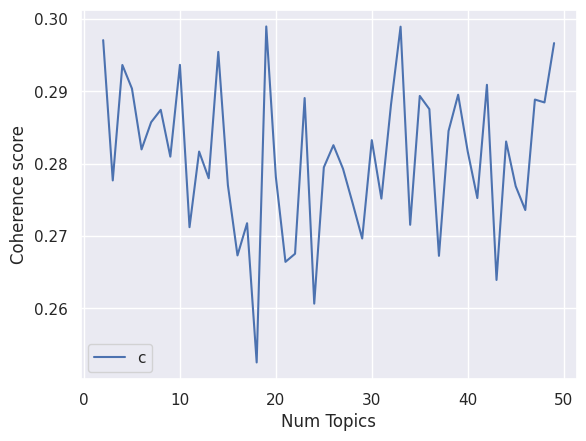

In [27]:
# Show graph
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [28]:
# Saving the coherence graph as an image file
coherence_graph_save_path = '/work/GitHub_ML_Deepnote/Machine Learning/4. LDA Topic Analysis/coherence_graph.png'
plt.savefig(coherence_graph_save_path)


<Figure size 640x480 with 0 Axes>

In [15]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.297
Num Topics = 3  has Coherence Value of 0.2777
Num Topics = 4  has Coherence Value of 0.2936
Num Topics = 5  has Coherence Value of 0.2904
Num Topics = 6  has Coherence Value of 0.282
Num Topics = 7  has Coherence Value of 0.2857
Num Topics = 8  has Coherence Value of 0.2874
Num Topics = 9  has Coherence Value of 0.281
Num Topics = 10  has Coherence Value of 0.2936
Num Topics = 11  has Coherence Value of 0.2712
Num Topics = 12  has Coherence Value of 0.2817
Num Topics = 13  has Coherence Value of 0.278
Num Topics = 14  has Coherence Value of 0.2954
Num Topics = 15  has Coherence Value of 0.277
Num Topics = 16  has Coherence Value of 0.2673
Num Topics = 17  has Coherence Value of 0.2718
Num Topics = 18  has Coherence Value of 0.2525
Num Topics = 19  has Coherence Value of 0.2989
Num Topics = 20  has Coherence Value of 0.2781
Num Topics = 21  has Coherence Value of 0.2664
Num Topics = 22  has Coherence Value of 0.2675
Num Topics = 23  has Coher

In [32]:
optimal_model = model_list[14]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(0,
  '0.013*"make" + 0.009*"would" + 0.009*"like" + 0.009*"think" + 0.008*"ai" + 0.007*"human" + 0.006*"even" + 0.006*"people" + 0.006*"point" + 0.006*"thing"'),
 (1,
  '0.012*"ai" + 0.011*"money" + 0.010*"u" + 0.010*"need" + 0.008*"would" + 0.008*"could" + 0.008*"come" + 0.008*"want" + 0.007*"say" + 0.007*"solution"'),
 (2,
  '0.016*"ai" + 0.013*"think" + 0.011*"human" + 0.007*"would" + 0.007*"conscious" + 0.006*"see" + 0.006*"im" + 0.005*"consciousness" + 0.005*"people" + 0.005*"system"'),
 (3,
  '0.018*"ai" + 0.012*"thing" + 0.011*"like" + 0.010*"think" + 0.010*"human" + 0.009*"say" + 0.008*"dont" + 0.008*"u" + 0.007*"would" + 0.007*"game"'),
 (4,
  '0.019*"ai" + 0.013*"think" + 0.012*"people" + 0.009*"human" + 0.009*"get" + 0.009*"intelligence" + 0.007*"would" + 0.006*"make" + 0.006*"way" + 0.006*"dont"'),
 (5,
  '0.024*"ai" + 0.018*"human" + 0.014*"could" + 0.010*"goal" + 0.009*"u" + 0.008*"would" + 0.006*"one" + 0.006*"design" + 0.005*"way" + 0.005*"brain"'),
 (6,
  '0.014*"ai"

In [34]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis_2 = pyLDAvis.gensim.prepare(optimal_model, doc_term_matrix, dictionary)
vis_2

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14    -0.037084  0.002868       1        1  21.046107
0     -0.024761  0.005748       2        1  11.597648
11    -0.000562 -0.026222       3        1  11.505973
4     -0.005069  0.017071       4        1   9.508812
9     -0.045777 -0.002848       5        1   7.675930
3     -0.034655 -0.026546       6        1   6.850879
13    -0.000400  0.056093       7        1   6.147700
8     -0.044399 -0.006348       8        1   4.434467
2      0.008619 -0.018134       9        1   4.240399
15    -0.033472  0.015845      10        1   3.978272
1      0.073237  0.087894      11        1   2.934749
7      0.012856 -0.011898      12        1   2.527933
5      0.049337 -0.047884      13        1   2.262163
6      0.055236 -0.027806      14        1   2.157770
10    -0.017163  0.031077      15        1   2.002620
12     0.044058 -0.048911      16        1   1.128577, topic_info=        Term        Freq       Total Category  logprob  loglift
5         ai  209.000000  209.000000  Default  30.0000  30.0000
153      say   69.000000   69.000000  Default  29.0000  29.0000
49     human  136.000000  136.000000  Default  28.0000  28.0000
142     goal   45.000000   45.000000  Default  27.0000  27.0000
213    could   63.000000   63.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
215   create    0.537593   38.974719  Topic16  -5.7014   0.2006
168  machine    0.515154   34.058079  Topic16  -5.7440   0.2929
330   people    0.532563   81.021617  Topic16  -5.7108  -0.5406
318     need    0.459082   48.434872  Topic16  -5.8592  -0.1745
51        im    0.454089   59.490703  Topic16  -5.8702  -0.3911

[1156 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
950       1  0.134279     ..
950       2  0.134279     ..
950       3  0.134279     ..
950       4  0.134279     ..
950       5  0.402838     ..
...     ...       ...    ...
416      12  0.020139  youre
416      13  0.020139  youre
416      14  0.020139  youre
416      15  0.020139  youre
585       6  0.918211     yr

[2287 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 1, 12, 5, 10, 4, 14, 9, 3, 16, 2, 8, 6, 7, 11, 13])

In [19]:
#The visualization with CSS styling for width and height
html_output = pyLDAvis.display(vis_2, False)
html_output.data = html_output.data.replace("80%", "600px").replace("1400px", "600px")


In [35]:
# Specifying the full path for saving the HTML file
html_save_path = '/work/GitHub_ML_Deepnote/Machine Learning/4. LDA Topic Analysis/corpus_optimal_lda.html'

# Saving as an HTML file
pyLDAvis.save_html(vis_2, html_save_path)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f64215d6-debc-46bd-b273-63565459a66d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>